# Experiments for the Nearest-advocate (NAd) Method for time delay estimation on semi-simulated event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors and implementations

**Experiments:**
1. runtime for different implementations
1. HP: sparse-factor

## TODO
- [ ] Implementation performance tests
- [ ] HP-experiment for NAd (variable noise and missing events)

In [1]:
import os
import sys
import time

import numpy as np
np.random.seed(0)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns


from multiprocessing import Pool
# Load methods
%matplotlib inline

In [2]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters to semi-simulate data
OFFSET = np.pi
SIGMA = 0.1

## Data

### Load the datasets

In [3]:
def load_heart_beats(path_to_dir: str=PATH_HEART_RATE_DATA, is_synched: bool=True, verbose: int=1):
    """Loads all pairs of heart rate data.
    
    Parameters
    ----------
    path_to_dir: str
        Path to the directory of heart beat data, containing the PSG and 
        already synchronized and shifted offbody measurement.
    is_synched: bool
        Load the signal data that is already synched and clock-drift corrected.
    verbose: int
        Show more output, 0 or larger.
    Returns
    -------
    pair_dataset : list
        List of tuples of two timestamp np.ndarrays for the R-peaks
    """
    ref_files = sorted([file for file in os.listdir(path_to_dir) 
                        if file.endswith("_nn.txt")])
    if is_synched:
        signal_files = [file for file in os.listdir(path_to_dir) 
                        if file.endswith("_beats_synced.csv")]
    else:
        signal_files = [file for file in os.listdir(path_to_dir) 
                        if file.endswith("_beats.csv")]
    
    # iterate through ref_files and load the data pairwise
    pair_dataset = list()
    for ref_file in ref_files:
        # skip files with the note 'm' in it
        if "m" in ref_file:
            continue
        pid = ref_file[1:].split("_nn")[0][:-1]
        
        # search number in signal_files, or continue
        for sig_file in signal_files:
            if pid in sig_file:
                break
        else:
            continue
        if verbose >= 1:
            print(f"Loading files {ref_file} and {sig_file}.")
        
        # load reference file
        arr_ref = pd.read_table(os.path.join(path_to_dir, ref_file), sep=",")["time"].values

        # load signal file 
        arr_sig = pd.read_csv(os.path.join(path_to_dir, ref_file))["time"].values
        
        # append to heart_beat_dataset
        pair_dataset.append((arr_ref, arr_sig))
    return pair_dataset
        
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [4]:
def load_breath_rate(path_to_dir: str=PATH_BREATH_RATE_DATA, verbose: int=1):
    """Loads all pairs of breath rate data (from Bra4Vit).
    
    Parameters
    ----------
    path_to_dir: str
        Path to the directory of heart beat data, containing the Reference and 
        SportsSRS measurement.
    verbose: int
        Show more output, 0 or larger.
    Returns
    -------
    pair_dataset : list
        List of tuples of two timestamp np.ndarrays for the FlowReversals
    """
    ref_files = sorted([file for file in os.listdir(path_to_dir) 
                        if "Reference" in file])
    signal_files = [file for file in os.listdir(path_to_dir) 
                    if "SportsSRS" in file]
    
    # iterate through ref_files and load the data pairwise
    pair_dataset = list()
    for ref_file in ref_files:
        # skip files with the note 'm' in it
        pid = ref_file[1:].split("_")[0]
        
        # search number in signal_files, or continue
        for sig_file in signal_files:
            if pid in sig_file:
                break
        else:
            continue
        if verbose >= 1:
            print(f"Loading files {ref_file} and {sig_file}.")
        
        # load reference file
        arr_ref = pd.read_csv(
            os.path.join(path_to_dir, ref_file), sep=";", usecols=["Time"], 
            converters={"Time": lambda x: float(x.replace(",", "."))}
        )["Time"].values

        # load signal file
        arr_sig = pd.read_csv(
            os.path.join(path_to_dir, sig_file), sep=";", usecols=["Time"], 
            converters={"Time": lambda x: float(x.replace(",", "."))}
        )["Time"].values

        # append to heart_beat_dataset
        pair_dataset.append((arr_ref, arr_sig))
    return pair_dataset
        
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P04_Reference_FlowReversals_OVERALL.csv and P04_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [5]:
def load_step_rate(path_to_dir: str=PATH_STEP_RATE_DATA, verbose: int=1):
    """Loads all pairs of breath rate data (from Bra4Vit).
    
    Parameters
    ----------
    path_to_dir: str
        Path to the directory of step beat data, containing the Reference and 
        SportsSRS measurement.
    verbose: int
        Show more output, 0 or larger.
    Returns
    -------
    pair_dataset : list
        List of tuples of two timestamp np.ndarrays for the FlowReversals
    """
    ref_files = sorted([file for file in os.listdir(path_to_dir) 
                        if "Reference" in file])
    signal_files = [file for file in os.listdir(path_to_dir) 
                    if "SportsSRS" in file]
    
    # iterate through ref_files and load the data pairwise
    pair_dataset = list()
    for ref_file in ref_files:
        # skip files with the note 'm' in it
        pid = ref_file[1:].split("_")[0]
        
        # search number in signal_files, or continue
        for sig_file in signal_files:
            if pid in sig_file:
                break
        else:
            continue
        if verbose >= 1:
            print(f"Loading files {ref_file} and {sig_file}.")
        
        # load reference file
        arr_ref = pd.read_csv(
            os.path.join(path_to_dir, ref_file), sep=";", usecols=["x"], 
            converters={"x": lambda x: float(x.replace(",", "."))}
        )["x"].values

        # load signal file
        arr_sig = pd.read_csv(
            os.path.join(path_to_dir, sig_file), sep=";", usecols=["x"], 
            converters={"x": lambda x: float(x.replace(",", "."))}
        )["x"].values

        # append to heart_beat_dataset
        pair_dataset.append((arr_ref, arr_sig))
    return pair_dataset
        
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P05_Reference_Strides_OVERALL.csv and P05_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P14_Reference_Strides_OVERALL.csv and P14_SportsSRS_Strides_OVERALL.csv.
Loading files P15_Reference_Strides_OVERALL

### Statistics of the datasets

In [6]:
n_measurements = 2 * len((heart_beat_dataset + breath_rate_dataset + step_rate_dataset))

df_measurements = pd.DataFrame(columns=["dataset", "length", "count", "mean_diff", "median_diff"], 
                               index=range(n_measurements))
idx = 0
for data_idx, dataset in enumerate((heart_beat_dataset, breath_rate_dataset, step_rate_dataset)):
    for m in dataset:
        for array in m:
            df_measurements.loc[idx, "dataset"] = {0: "HR", 1: "BR", 2: "SR"}.get(data_idx)
            df_measurements.loc[idx, "count"] = len(array)
            df_measurements.loc[idx, "length"] = array[-1] - array[0]
            df_measurements.loc[idx, "mean_diff"] = np.mean(np.diff(array))
            df_measurements.loc[idx, "median_diff"] = np.median(np.diff(array))
            idx += 1

In [7]:
df_measurements.describe()

,dataset,length,count,mean_diff,median_diff
count,110,110.000,110,110.000000,110.0
unique,3,93.000,91,93.000000,81.0
top,BR,28918.762,28662,1.008993,0.9
freq,38,2.000,2,2.000000,4.0


In [8]:
# how many datasets, events and total number of seconds does we have
df_measurements.groupby("dataset").agg({"dataset": "count", "count": "sum", "length": "sum"})

,dataset,count,length
dataset,,,
BR,38,89195,94026.521
HR,34,941594,972334.232
SR,38,201869,92021.41061


In [9]:
# melt the dataset for the plot
df_measurements_melted = pd.melt(
    df_measurements, id_vars="dataset", var_name="measurement", 
    value_vars=["count", "length", "mean_diff", "median_diff"], value_name="value")

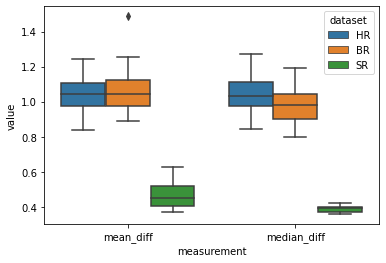

In [10]:
df_tmp = df_measurements_melted[df_measurements_melted["measurement"].isin(["mean_diff", "median_diff"])]
sns.boxplot(data=df_tmp, 
            y="value", x="measurement", hue="dataset")
plt.show()

## Function to semi-simulate the data

In [11]:
def modify_timeseries(arr: np.ndarray, offset: float=0, sigma: float=0.0, fraction: float=1.0):
    """Modify a event-based timeseries in order generate semi-simulated data.
    
    Parameters
    ----------
    arr: np.ndarray
        Array to modify
    offset: float
        Offset to shift the time-series
    sigma: float
        Amount of noise, relative to the median difference of subsequent events
    fraction: float
        Fraction of events used
        
    Returns
    -------
    arr_modified : np.ndarray
        Modified array
    """
    arr_mod = arr.copy()
    
    # shift the array
    arr_mod += offset
    
    # add gaussian noise to the events
    arr_mod = arr_mod + np.random.normal(loc=0, scale=sigma*np.median(np.diff(arr)), size=len(arr_mod))
    
    # sort the array to maintain continuity
    arr_mod.sort()
    
    # select the fraction of events
    if fraction < 1.0:
        arr_mod = arr_mod[np.random.random(len(arr_mod))<fraction]
    
    return arr_mod

_ = modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, sigma=0.1, fraction=0.5)

## Define Methods

In [12]:
# TODO define other functions

## Performance comparision for different implementations

In [24]:
N = 10_000               # number of events in the random arrays
TIME_SHIFT = np.pi        # true time-shift between the two arrays
DEF_DIST = 0.25           # default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 60               # search space of +-1 minutes
TD_MIN = -60
SAMPLES_PER_S = 20       # precision of the search space

In [25]:
sys.path.append("../src")

In [26]:
# Create two related event-based array, they differ by a time-shift and gaussian noise
arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=N)))
arr_sig = np.sort(arr_ref + TIME_SHIFT + np.random.normal(loc=0, scale=0.1, size=N))

In [29]:
# Time the numba-solution
from nearest_advocate_nb import nearest_advocate
# run once before the test to just-in-time compile it
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

start_time = time.time()
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)
pytime = time.time() - start_time
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Numba:   \t{pytime:.8f} s, \t detected time shift: {time_shift:.2f} s, \t minimal mean distance: {min_mean_dist:.6f} s")

Numba:   	0.12116647 s, 	 detected time shift: 3.15 s, 	 minimal mean distance: 0.079508 s


In [30]:
%%timeit -n 1000 -r 7
_ = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

1.97827 ms ± 4.26764 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [42]:
# Time the Cython-solution
from nearest_advocate_c import nearest_advocate
start_time = time.time()
np_nearest = nearest_advocate(arr_ref=arr_ref.astype(np.float32), arr_sig=arr_sig.astype(np.float32), 
                                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                                dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)
pytime = time.time() - start_time
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Cython:   \t{pytime:.8f} s, \t detected time shift: {time_shift:.2f} s, \t minimal mean distance: {min_mean_dist:.6f} s")

Cython:   	0.11686993 s, 	 detected time shift: 3.15 s, 	 minimal mean distance: 0.079509 s


In [32]:
%%timeit -n 1000 -r 7
_ = nearest_advocate(arr_ref=arr_ref.astype(np.float32), arr_sig=arr_sig.astype(np.float32), 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

1.78804 ms ± 3.75851 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
# Time the pure Python-solution
from nearest_advocate_python import nearest_advocate
start_time = time.time()
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)
pytime = time.time() - start_time
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Python:   \t{pytime:.8f} s, \t detected time shift: {time_shift:.2f} s, \t minimal mean distance: {min_mean_dist:.6f} s")


Python:   	28.21545792 s, 	 detected time shift: 3.15 s, 	 minimal mean distance: 0.079508 s


In [34]:
%%timeit -n 1 -r 7
_ = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

469.413 ms ± 4.28792 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
(1.78804-1.97827)/1.78804

-0.10639023735486895

## Hyperparameter Optimization for Nearest-Advocate

In [44]:
import numpy as np
from numba import njit

DIST_MAX = -1.0           # use the default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 60               # search space of +-1 minutes
TD_MIN = -60
SAMPLES_PER_S = 10        # precision of the search space

@njit(parallel=False)
def nearest_advocate_single(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                            dist_max: float, dist_padding: float, regulate_paddings: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    regulate_paddings (bool): Regulate non-overlapping events in arr_sig with a maximum distance of err_max, default True
    dist_padding (float): Distance assigned to non-overlapping (padding) events, should be 1/4 of the median gap of arr_ref. Only given if regulate_paddings is True
    '''
    # Assert input properties
    assert arr_ref.shape[0] > 0    # reference array must be non-empty
    assert arr_sig.shape[0] > 0    # signal array must be non-empty
    assert dist_max > 0.0          # maximal distance must be greater than 0.0
    if regulate_paddings:
        assert dist_padding > 0.0  # maximal distance for paddings must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
            
    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    counter = 0              # number of advocate events
    cum_distance = 0.0       # cumulative distances between advocate events
    
    # Step 1: cut leading reference timestamps without finding advocates
    while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1
        
    # return dist_max, if arr_ref ends before arr_sig starts
    if ref_idx+1 == l_arr_ref:
        return dist_max
    
    # Case: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
    assert arr_ref[ref_idx+1] > arr_sig[sig_idx]
    
    # Step 2: count leading signal timestamps with finding advocates
    while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
        # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
        if regulate_paddings:
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_padding)
            counter += 1
        sig_idx += 1
        
    # return dist_max, if arr_sig ends before arr_ref starts
    if sig_idx == l_arr_sig:
        return dist_max     
    
    # Step 3 (regular case) and step 4 (match trailing signal timestamps)
    while sig_idx < l_arr_sig:
        # Step 3: regular case
        if arr_sig[sig_idx] < arr_ref[-1]:
            # forward arr_ref and then arr_sig until regalar case
            while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx+1 >= l_arr_ref: 
                sig_idx += 1
                continue
            # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
            # assert arr_ref[ref_idx] <= arr_sig[sig_idx]
            # assert arr_sig[sig_idx] < arr_ref[ref_idx+1]
            
            cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max) 
            counter += 1
        # Step 4: match trailing reference timestamps with last signal timestamp
        elif regulate_paddings:  
            # Invariant: arr_ref[ref_idx+1] <= arr_sig[sig_idx], given by the else case
            if arr_sig[sig_idx]-arr_ref[ref_idx+1] < dist_padding:
                cum_distance += arr_sig[sig_idx]-arr_ref[ref_idx+1]
                counter += 1
            else: 
                # case with only dist_padding increments from now on
                cum_distance += (l_arr_sig - sig_idx) * dist_padding
                counter += (l_arr_sig - sig_idx)
                break # stop, because the last values can be aggregated
                
        sig_idx += 1
    
    # return mean cumulative distance between found advocate events
    return cum_distance / counter


@njit(parallel=False)
def nearest_advocate(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                     td_min: float, td_max: float, sps: float=10, sparse_factor: int=1, 
                     dist_max: float=0.0, regulate_paddings: bool=True, dist_padding: float=0.0):
    '''Calculates the synchronicity of two arrays of timestamps for a search space between td_min and td_max with a precision of 1/sps. The synchronicity is given by the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    td_min (float): lower bound of the search space for the time-shift
    td_max (float): upper bound of the search space for the time-shift
    sps (int): number of investigated time-shifts per second, should be higher than 10 times the number of median gap of arr_ref (default 10).
    sparse_factor (int): factor for the sparseness of arr_sig for the calculation, higher is faster but may be less accurate (default 1)
    dist_max (None, float): Maximal accepted distances, default None: 1/4 of the median gap of arr_ref
    dist_padding (None, float): Assumed distances of non-overlapping (padding) matches, default None: 1/4 of the median gap of arr_ref
    regulate_paddings (bool): regulate non-overlapping events in arr_sig with a maximum distance of err_max
    '''
    # set the default values for dist_max, dist_padding relative if not set
    # TODO improve default value: min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
    if dist_max <= 0.0:
        dist_max = np.median(np.diff(arr_ref))/4
    if dist_padding <= 0.0:
        dist_padding = np.median(np.diff(arr_ref))/4
        
    # Random subsample and create a copy of arr_sig once, as it could lead to problems otherwise
    if sparse_factor > 1:
        probe = arr_sig[sparse_factor//2::sparse_factor].copy()
    else:
        probe = arr_sig.copy()
    
    # Create an k x 2 matrix to store the investigated time-shifts and their respective mean distance
    np_nearest = np.empty((int((td_max-td_min)*sps), 2), dtype=np.float32)
    np_nearest[:, 0] = np.arange(td_min, td_max, 1/sps)
    
    # Calculate the mean distance for all time-shifts in the search space. 
    # The shift with the lowest mean distance is the best fit for the time-shift
    idx = 0
    while idx < np_nearest.shape[0]:
        # calculate the nearest advocate criteria
        np_nearest[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-np_nearest[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1
    return np_nearest

# run once before the test to just-in-time compile it
arr_ref = np.arange(0, 100).astype(np.float32)
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_ref+np.pi, 
                             td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s")

Found optimum for a time shift of 0.100s


### Experiment 1: Find the optimal sparse-factor

In [26]:
LENGTHS = [int(l) for l in [1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]]
N_ITERATIONS = 20         # number of iterations per length, used for the interquartils
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'NAd-sparse1000', 'NAd-sparseopt']  # TODO: add method specifics
REF_SIGMA = 0.5
SIGMA = 0.25
FRACTION = 0.9

In [27]:
# evaluate a given length
def evaluate_length(iteration):
    # define the local DataFrame for one single pair
    df_runtimes = pd.DataFrame({m: np.nan*np.zeros(len(LENGTHS)) for m in METHODS})
    df_runtimes["length"] = LENGTHS
    df_precision = pd.DataFrame({m: np.nan*np.zeros(len(LENGTHS)) for m in METHODS})
    df_precision["length"] = LENGTHS

    for idx, length in enumerate(LENGTHS):
        np.random.seed(N_ITERATIONS*iteration+idx)
        # Create two related event-based array, they differ by a time-shift and gaussian noise
        arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=REF_SIGMA, size=int(length)))).astype(np.float32)
        arr_sig = np.sort(arr_ref + OFFSET + np.random.normal(loc=0, scale=SIGMA, size=int(length))).astype(np.float32)

        # NAd-dense
        start_time = time.time()
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_runtimes.loc[idx, "NAd-dense"] = time.time() - start_time
        df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-OFFSET)

        # NAd-sparse10
        start_time = time.time()
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_runtimes.loc[idx, "NAd-sparse10"] = time.time() - start_time
        df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift-OFFSET)

        # NAd-sparse100
        start_time = time.time()
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_runtimes.loc[idx, "NAd-sparse100"] = time.time() - start_time
            df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift-OFFSET)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")

        # NAd-sparse1000
        start_time = time.time()
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1000, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_runtimes.loc[idx, "NAd-sparse1000"] = time.time() - start_time
            df_precision.loc[idx, "NAd-sparse1000"] = np.abs(time_shift-OFFSET)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")

        # NAd-sparseopt
        start_time = time.time()
        try:
            sparse_optimal = int(max(1, length/250))
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=sparse_optimal, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_runtimes.loc[idx, "NAd-sparseopt"] = time.time() - start_time
            df_precision.loc[idx, "NAd-sparseopt"] = np.abs(time_shift-OFFSET)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")
        
        # PCC-FFT TODO
        # PCC-DFT TODO
        # KCC (with multiple settings?) TODO
        # DTW (with multiple settings?) TODO
    
    return df_runtimes, df_precision
    
# Initialize the pool with the number of processes
with Pool(processes=30) as pool: 
    results = pool.map(evaluate_length, range(N_ITERATIONS))
df_runtimes = pd.concat([res[0] for res in results]).sort_values("length")
df_precision = pd.concat([res[1] for res in results]).sort_values("length")

In [28]:
for length in LENGTHS:
    sparse_optimal = int(max(1, length/250))
    print(f"Lenght={length}, optimal sparse factor: {sparse_optimal}")

Lenght=10, optimal sparse factor: 1
Lenght=20, optimal sparse factor: 1
Lenght=50, optimal sparse factor: 1
Lenght=100, optimal sparse factor: 1
Lenght=200, optimal sparse factor: 1
Lenght=500, optimal sparse factor: 2
Lenght=1000, optimal sparse factor: 4
Lenght=2000, optimal sparse factor: 8
Lenght=5000, optimal sparse factor: 20
Lenght=10000, optimal sparse factor: 40
Lenght=20000, optimal sparse factor: 80
Lenght=50000, optimal sparse factor: 200
Lenght=100000, optimal sparse factor: 400
Lenght=200000, optimal sparse factor: 800
Lenght=500000, optimal sparse factor: 2000
Lenght=1000000, optimal sparse factor: 4000


In [29]:
df_runtimes.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,NAd-sparse1000,NAd-sparseopt,length
3,0.000696,0.000161,0.000087,NaN,0.000689,100
10,0.202203,0.037354,0.014187,0.011613,0.014804,20000
15,10.304332,1.916819,0.712803,0.597736,0.587111,1000000
9,0.101165,0.018487,0.007176,0.005752,0.009177,10000
11,0.504780,0.094380,0.035276,0.029246,0.032026,50000


In [30]:
df_precision.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,NAd-sparse1000,NAd-sparseopt,length
8,0.041593,0.041593,0.041593,6.058407,0.041593,5000
2,0.058407,11.841592,NaN,NaN,0.058407,50
3,0.041593,3.141593,30.441592,NaN,0.041593,100
6,0.058407,0.041593,2.558407,53.341593,0.041593,1000
1,0.141593,2.858407,NaN,NaN,0.141593,20


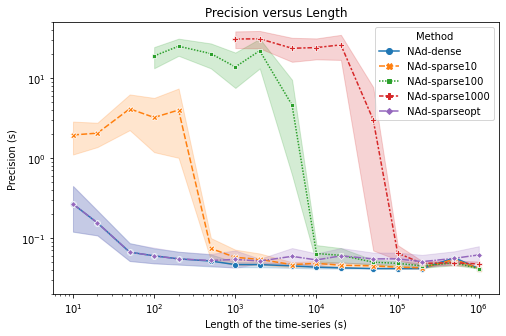

In [31]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="length", y="precision", 
                              hue="Method", style="Method", markers=True, ci=95)
plt.title("Precision versus Length")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("Precision (s)")
plt.ylim((0.02, 50))
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.show()

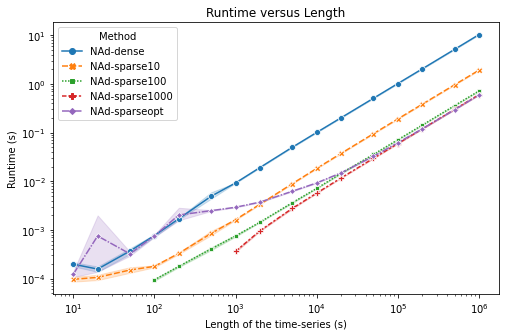

In [32]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_runtimes_melted = pd.melt(df_runtimes, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="runtime")
precision_plot = sns.lineplot(data=df_runtimes_melted, 
                              x="length", y="runtime", 
                              hue="Method", style="Method", markers=True, ci=95)
plt.title("Runtime versus Length")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("Runtime (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.show()

### NAd-Optimization - Experiment 1: Robustness against missing events

TODO: check the results, they are not as expected

In [33]:
FRACTIONS = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
METHODS = ['NAd-median', 'NAd-minmedian', 'NAd-mean', 'NAd-minmean']  # TODO: add method specifics
SIGMA = 0.1               # run with a relative sigma of 0.1
OFFSET = np.pi            # true time-shift between the two arrays

In [53]:
# evaluate a given fraction
def evaluate_fraction(fraction):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    # measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            semi_simulated_pairs.append(
                (modify_timeseries(arr=array, offset=0.0, sigma=SIGMA, fraction=fraction), 
                 modify_timeseries(arr=array, offset=OFFSET, sigma=SIGMA, fraction=fraction))
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["fraction"] = [fraction for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig) in enumerate(semi_simulated_pairs):
        # arr_ref = modify_timeseries(arr=arr_ref_orig, offset=0.0, sigma=SIGMA, fraction=fraction)
        
        # # NAd-dense
        # start_time = time.time()
        # np_nearest = nearest_advocate(
        #     arr_ref=arr_ref, arr_sig=arr_sig, 
        #     td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
        #     dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        # time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        # df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-OFFSET)

        # NAd-median
        start_time = time.time()
        dist_max = np.median(np.diff(arr_ref)) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-median"] = np.abs(time_shift-OFFSET)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmedian"] = np.abs(time_shift-OFFSET)

        # NAd-mean
        start_time = time.time()
        dist_max = np.mean(np.diff(arr_ref)) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-mean"] = np.abs(time_shift-OFFSET)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.mean(np.diff(arr_sig)), np.mean(np.diff(arr_ref))) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmean"] = np.abs(time_shift-OFFSET)
    
    return df_precision
    
    
# Initialize the pool with the number of processes
with Pool(processes=16) as pool: 
    results = pool.map(evaluate_fraction, FRACTIONS)
df_precision = pd.concat(results).sort_values("fraction")
df_precision.head(5)

,NAd-median,NAd-minmedian,NAd-mean,NAd-minmean,fraction
0,55.558408,55.558408,8.741593,7.441593,0.01
80,24.458408,24.458408,24.458408,24.458408,0.01
79,42.358407,42.458406,42.358407,42.458406,0.01
78,11.458408,11.458408,11.458408,11.458408,0.01
77,33.541592,33.541592,33.641593,33.641593,0.01


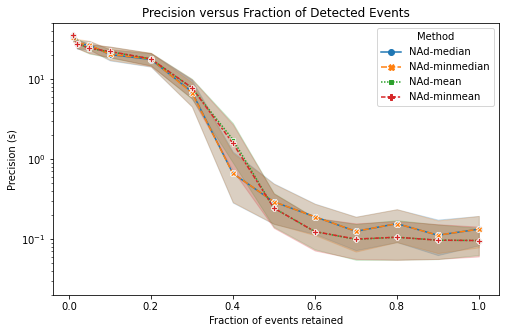

In [54]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="fraction", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="fraction", y="precision", 
                              hue="Method", style="Method", markers=True, ci=95)
plt.title("Precision versus Fraction of Detected Events")
plt.xlabel("Fraction of events retained")
plt.ylabel("Precision (s)")
plt.ylim((0.02, 50))
precision_plot.set(yscale='log')
# precision_plot.set(xscale='log')
plt.show()

### NAd-Optimization - Experiment: Use different DIST_MAX

TODO: check the results, they are not as expected

In [55]:
FACTORS = [0.01, 0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 2.0]
METHODS = ['NAd-median', 'NAd-minmedian', 'NAd-mean', 'NAd-minmean']  # TODO: add method specifics
SIGMA = 0.25               # run with a relative sigma of 0.1
FRACTION = 0.75            # run with a fraction of 0.9
OFFSET = np.pi            # true time-shift between the two arrays
REGULATE_PADDINGS = False

In [56]:
# evaluate a given fraction
def evaluate_factor(factor):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            semi_simulated_pairs.append(
                (modify_timeseries(arr=array, offset=0.0, sigma=SIGMA, fraction=FRACTION),
                 modify_timeseries(arr=array, offset=OFFSET, sigma=SIGMA, fraction=FRACTION))
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["factor"] = [factor for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig) in enumerate(semi_simulated_pairs):        
        # # NAd-dense
        # start_time = time.time()
        # np_nearest = nearest_advocate(
        #     arr_ref=arr_ref, arr_sig=arr_sig, 
        #     td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
        #     dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        # time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        # df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-OFFSET)

        # NAd-median
        start_time = time.time()
        dist_max = np.median(np.diff(arr_ref)) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-median"] = np.abs(time_shift-OFFSET)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmedian"] = np.abs(time_shift-OFFSET)

        # NAd-mean
        start_time = time.time()
        dist_max = np.mean(np.diff(arr_ref)) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-mean"] = np.abs(time_shift-OFFSET)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.mean(np.diff(arr_sig)), np.mean(np.diff(arr_ref))) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmean"] = np.abs(time_shift-OFFSET)

    return df_precision
    
# Initialize the pool with the number of processes
with Pool(processes=16) as pool: 
    results = pool.map(evaluate_factor, FACTORS)
df_precision = pd.concat(results).sort_values("factor")
df_precision.head(5)

,NAd-median,NAd-minmedian,NAd-mean,NAd-minmean,factor
0,60.741591,60.741591,36.658407,36.658407,0.01
21,7.158408,7.158408,16.141593,16.141593,0.01
22,35.841593,35.841593,13.358407,13.358407,0.01
23,3.758407,3.758407,11.658408,11.658408,0.01
24,29.458406,29.458406,0.041593,0.041593,0.01


In [57]:
df_precision.sample(5)

,NAd-median,NAd-minmedian,NAd-mean,NAd-minmean,factor
25,0.041593,0.041593,0.041593,0.041593,0.60
17,0.041593,0.041593,0.041593,0.041593,0.50
34,0.058407,0.058407,0.058407,0.058407,0.20
35,0.041593,0.041593,0.041593,0.041593,0.30
15,0.058407,0.058407,0.058407,0.058407,0.25


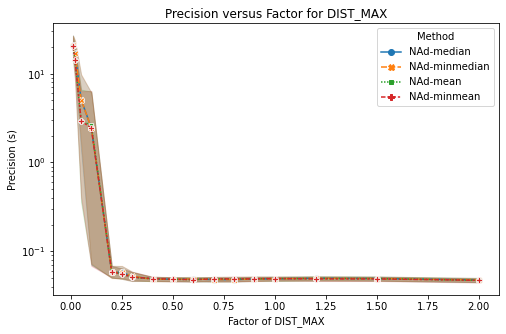

In [58]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="factor", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="factor", y="precision", 
                              hue="Method", style="Method", markers=True, ci=95)
plt.title("Precision versus Factor for DIST_MAX")
plt.xlabel("Factor of DIST_MAX")
plt.ylabel("Precision (s)")
# plt.ylim((0.0, 0.5))
precision_plot.set(yscale='log')
# precision_plot.set(xscale='log')
plt.show()

In [59]:
df_precision_melted.sort_values("precision").head(10)

,factor,Method,precision
1291,2.0,NAd-minmedian,0.041593
1473,0.2,NAd-mean,0.041593
1472,0.2,NAd-mean,0.041593
1471,0.2,NAd-mean,0.041593
1470,0.2,NAd-mean,0.041593
1469,0.2,NAd-mean,0.041593
1468,0.2,NAd-mean,0.041593
1461,0.2,NAd-mean,0.041593
1459,0.2,NAd-mean,0.041593
1452,0.2,NAd-mean,0.041593


In [60]:
df_precision_melted.groupby(["factor", "Method"]).agg({"precision": "mean"}).sort_values("precision")

precision
factor Method                  
2.00   NAd-mean        0.047345
       NAd-minmean     0.047345
       NAd-minmedian   0.047788
       NAd-median      0.047788
0.80   NAd-minmedian   0.048230
       NAd-median      0.048230
0.70   NAd-minmedian   0.048230
       NAd-median      0.048230
0.60   NAd-minmean     0.048230
       NAd-mean        0.048230
0.50   NAd-minmedian   0.048673
       NAd-minmean     0.048673
       NAd-mean        0.048673
0.40   NAd-minmedian   0.048673
0.50   NAd-median      0.048673
0.60   NAd-median      0.049115
       NAd-minmedian   0.049115
0.70   NAd-mean        0.049115
1.00   NAd-minmedian   0.049115
0.70   NAd-minmean     0.049115
1.00   NAd-median      0.049115
1.50   NAd-minmean     0.049115
0.90   NAd-minmedian   0.049115
       NAd-minmean     0.049115
       NAd-median      0.049115
       NAd-mean        0.049115
1.20   NAd-minmean     0.049115
0.80   NAd-minmean     0.049115
0.40   NAd-mean        0.049115
       NAd-median      0.049115
0.80   NAd-mean        0.049115
1.50   NAd-mean        0.049558
0.40   NAd-minmean     0.049558
1.00   NAd-mean        0.049558
       NAd-minmean     0.049558
1.20   NAd-mean        0.049558
1.50   NAd-median      0.049558
       NAd-minmedian   0.049558
1.20   NAd-median      0.050000
       NAd-minmedian   0.050000
0.30   NAd-mean        0.051304
       NAd-minmean     0.051304
       NAd-median      0.052189
       NAd-minmedian   0.052632
0.25   NAd-mean        0.055706
       NAd-minmean     0.055706
0.20   NAd-median      0.058337
       NAd-minmedian   0.058337
0.25   NAd-minmedian   0.058337
       NAd-median      0.058337
0.20   NAd-mean        0.058780
       NAd-minmean     0.058780
0.10   NAd-minmean     2.433326
       NAd-minmedian   2.439031
       NAd-median      2.439031
       NAd-mean        2.612273
0.05   NAd-minmean     2.935957
       NAd-mean        2.935957
       NAd-minmedian   5.093852
       NAd-median      5.093852
0.02   NAd-minmean    14.087704
       NAd-mean       14.087704
       NAd-median     17.199115
       NAd-minmedian  17.199115
0.01   NAd-minmean    20.353074
       NAd-mean       20.353074
       NAd-median     20.982906
       NAd-minmedian  20.982906